# Food Classification with Transfer Learning

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [5]:
# %cd ./food11

In [6]:
# All available classes
class_names = os.listdir("training")
class_names

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [8]:
# Check the number of images in training, validation and evaluation dataset
train = []
valid = []
test = []

for i  in class_names:
    train.extend(os.listdir(os.path.join('training', i)))
    valid.extend(os.listdir(os.path.join('validation', i)))
    test.extend(os.listdir(os.path.join('evaluation', i)))
    

print('Number of train images: {} \nNumber of validation images: {} \nNumber of test images: {}'.format(len(train),len(valid),len(test)))


Number of train images: 9866 
Number of validation images: 3430 
Number of test images: 3347


### Explolatory Data Analysis 

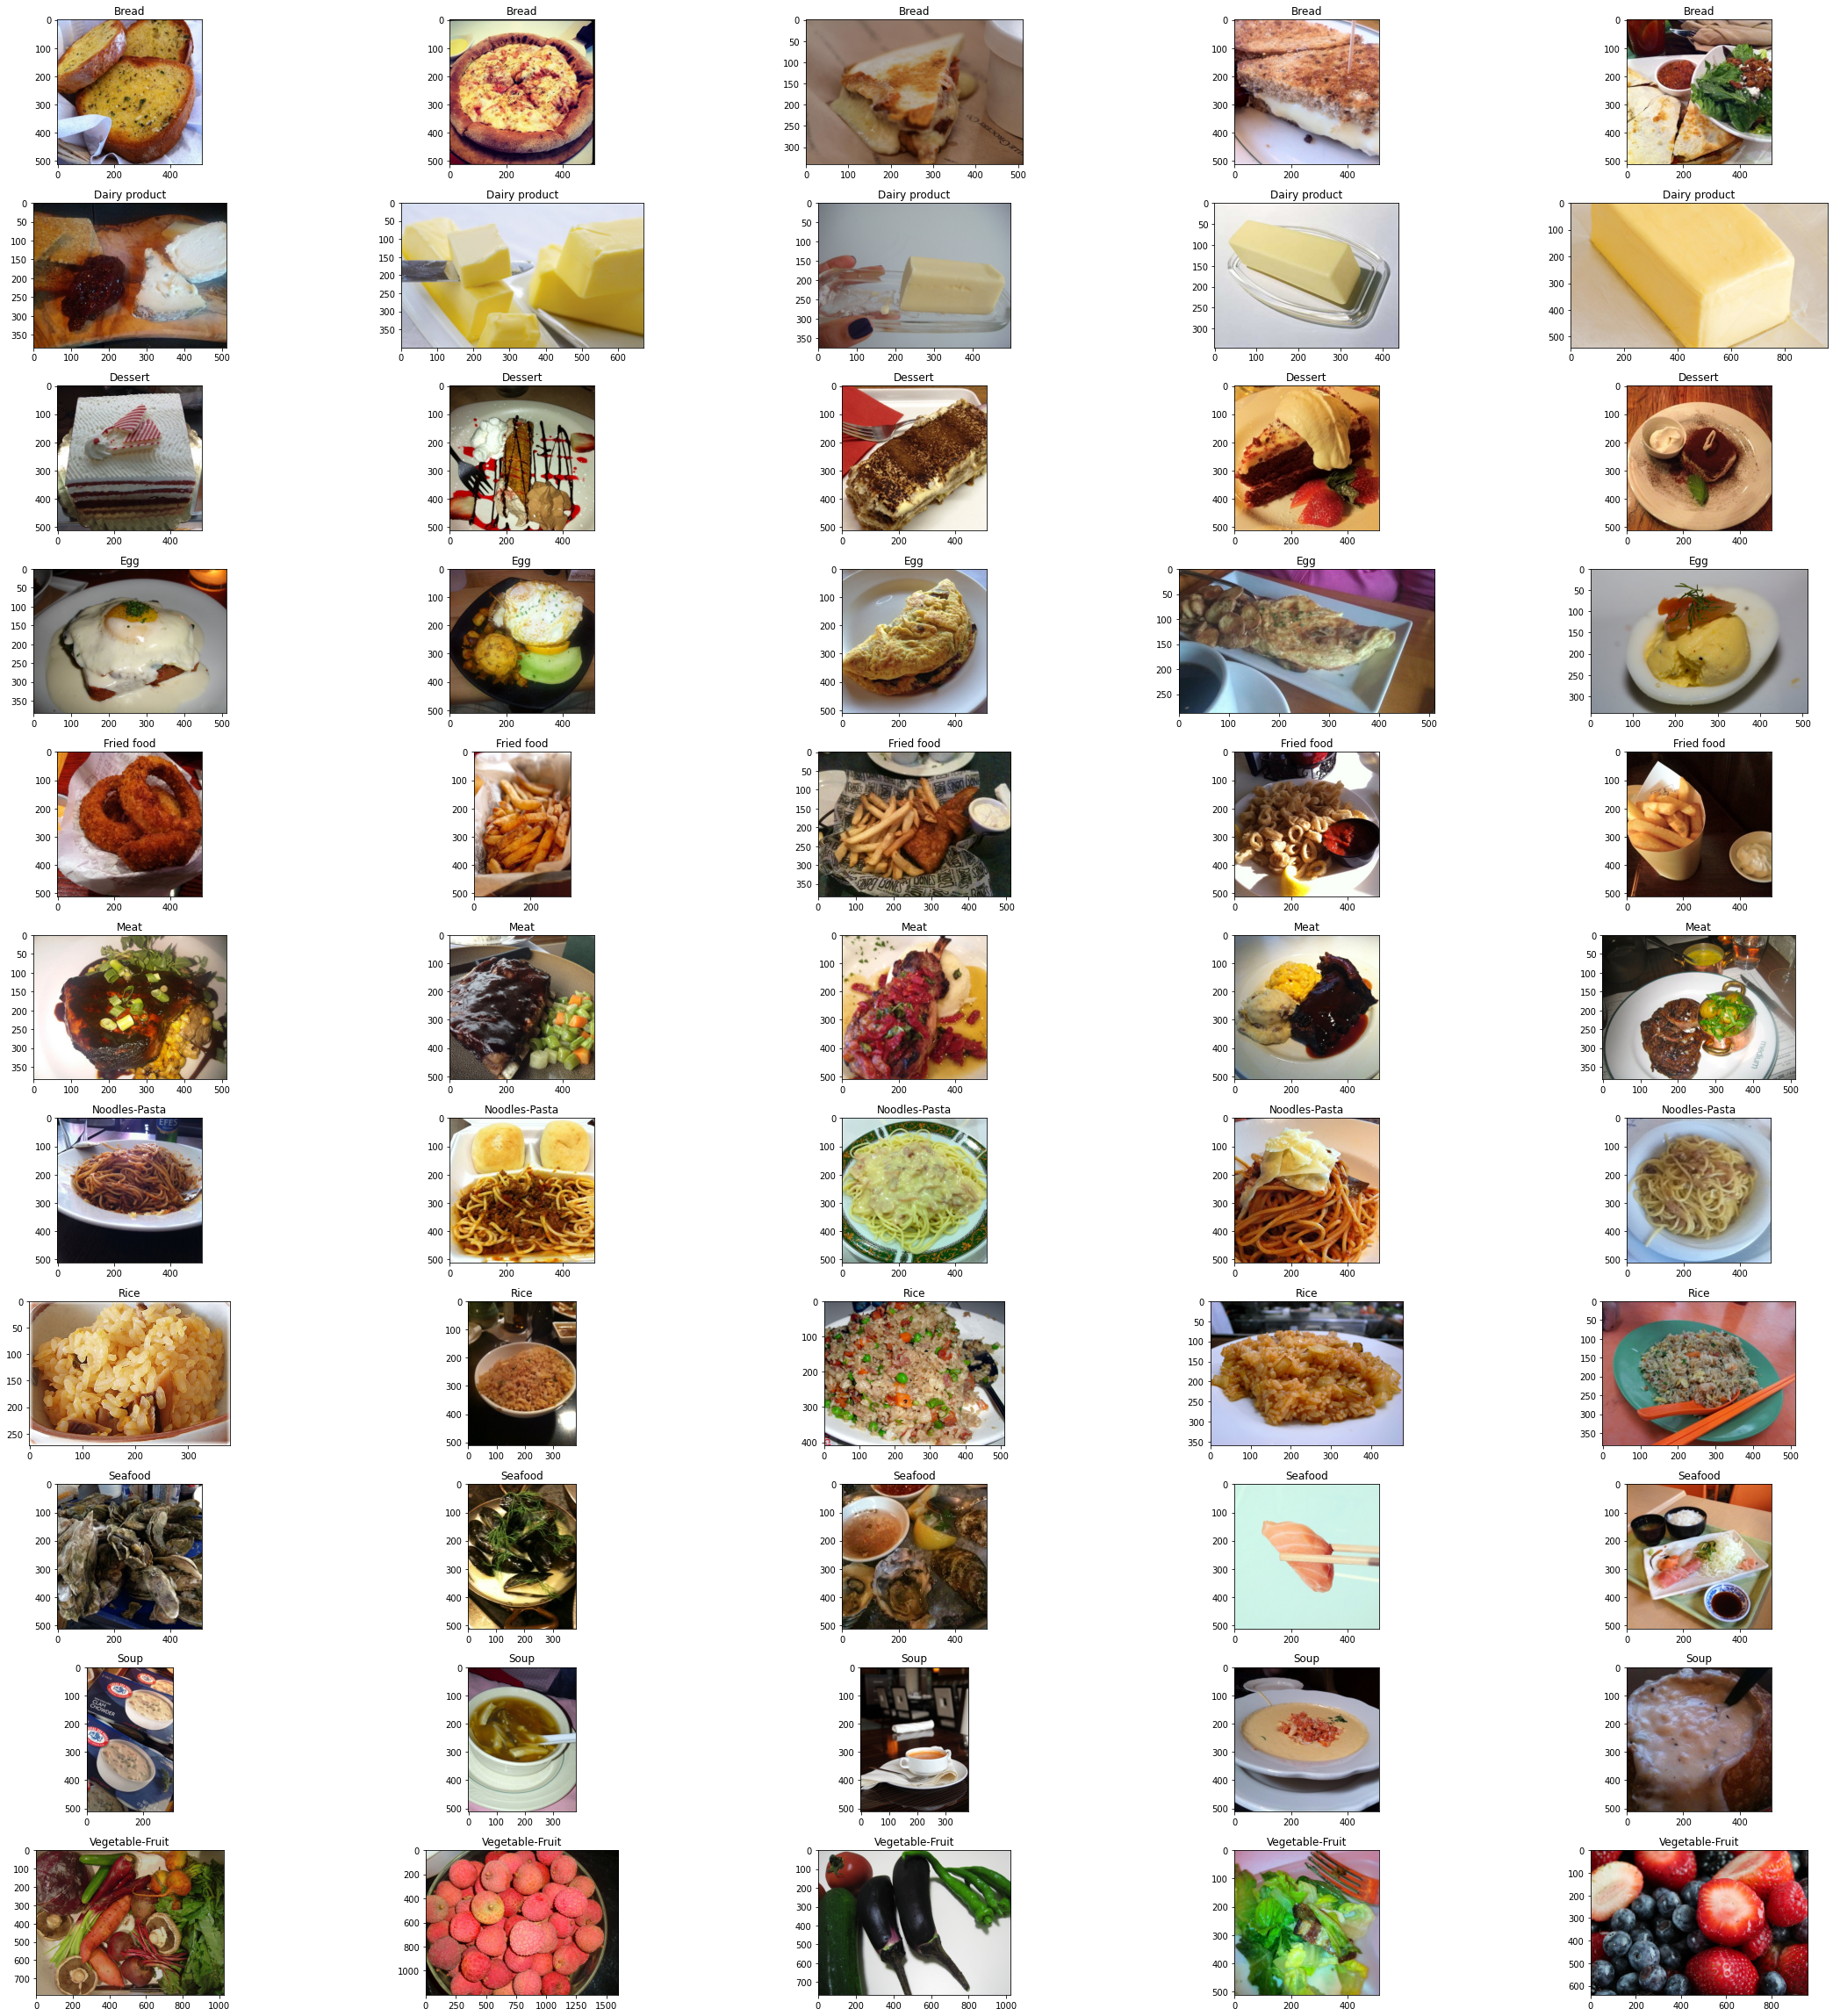

In [10]:
# Visualize the images in the training data

fig, axs = plt.subplots(11, 5, figsize = (32,32))
count = 0
# for every class in the dataset
for i in os.listdir('./training'):
  # get the list of all images that belong to a particular class
  train_class = os.listdir(os.path.join('training', i))
  
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('training', i, train_class[j])
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(PIL.Image.open(img))  
  count += 1

fig.tight_layout()


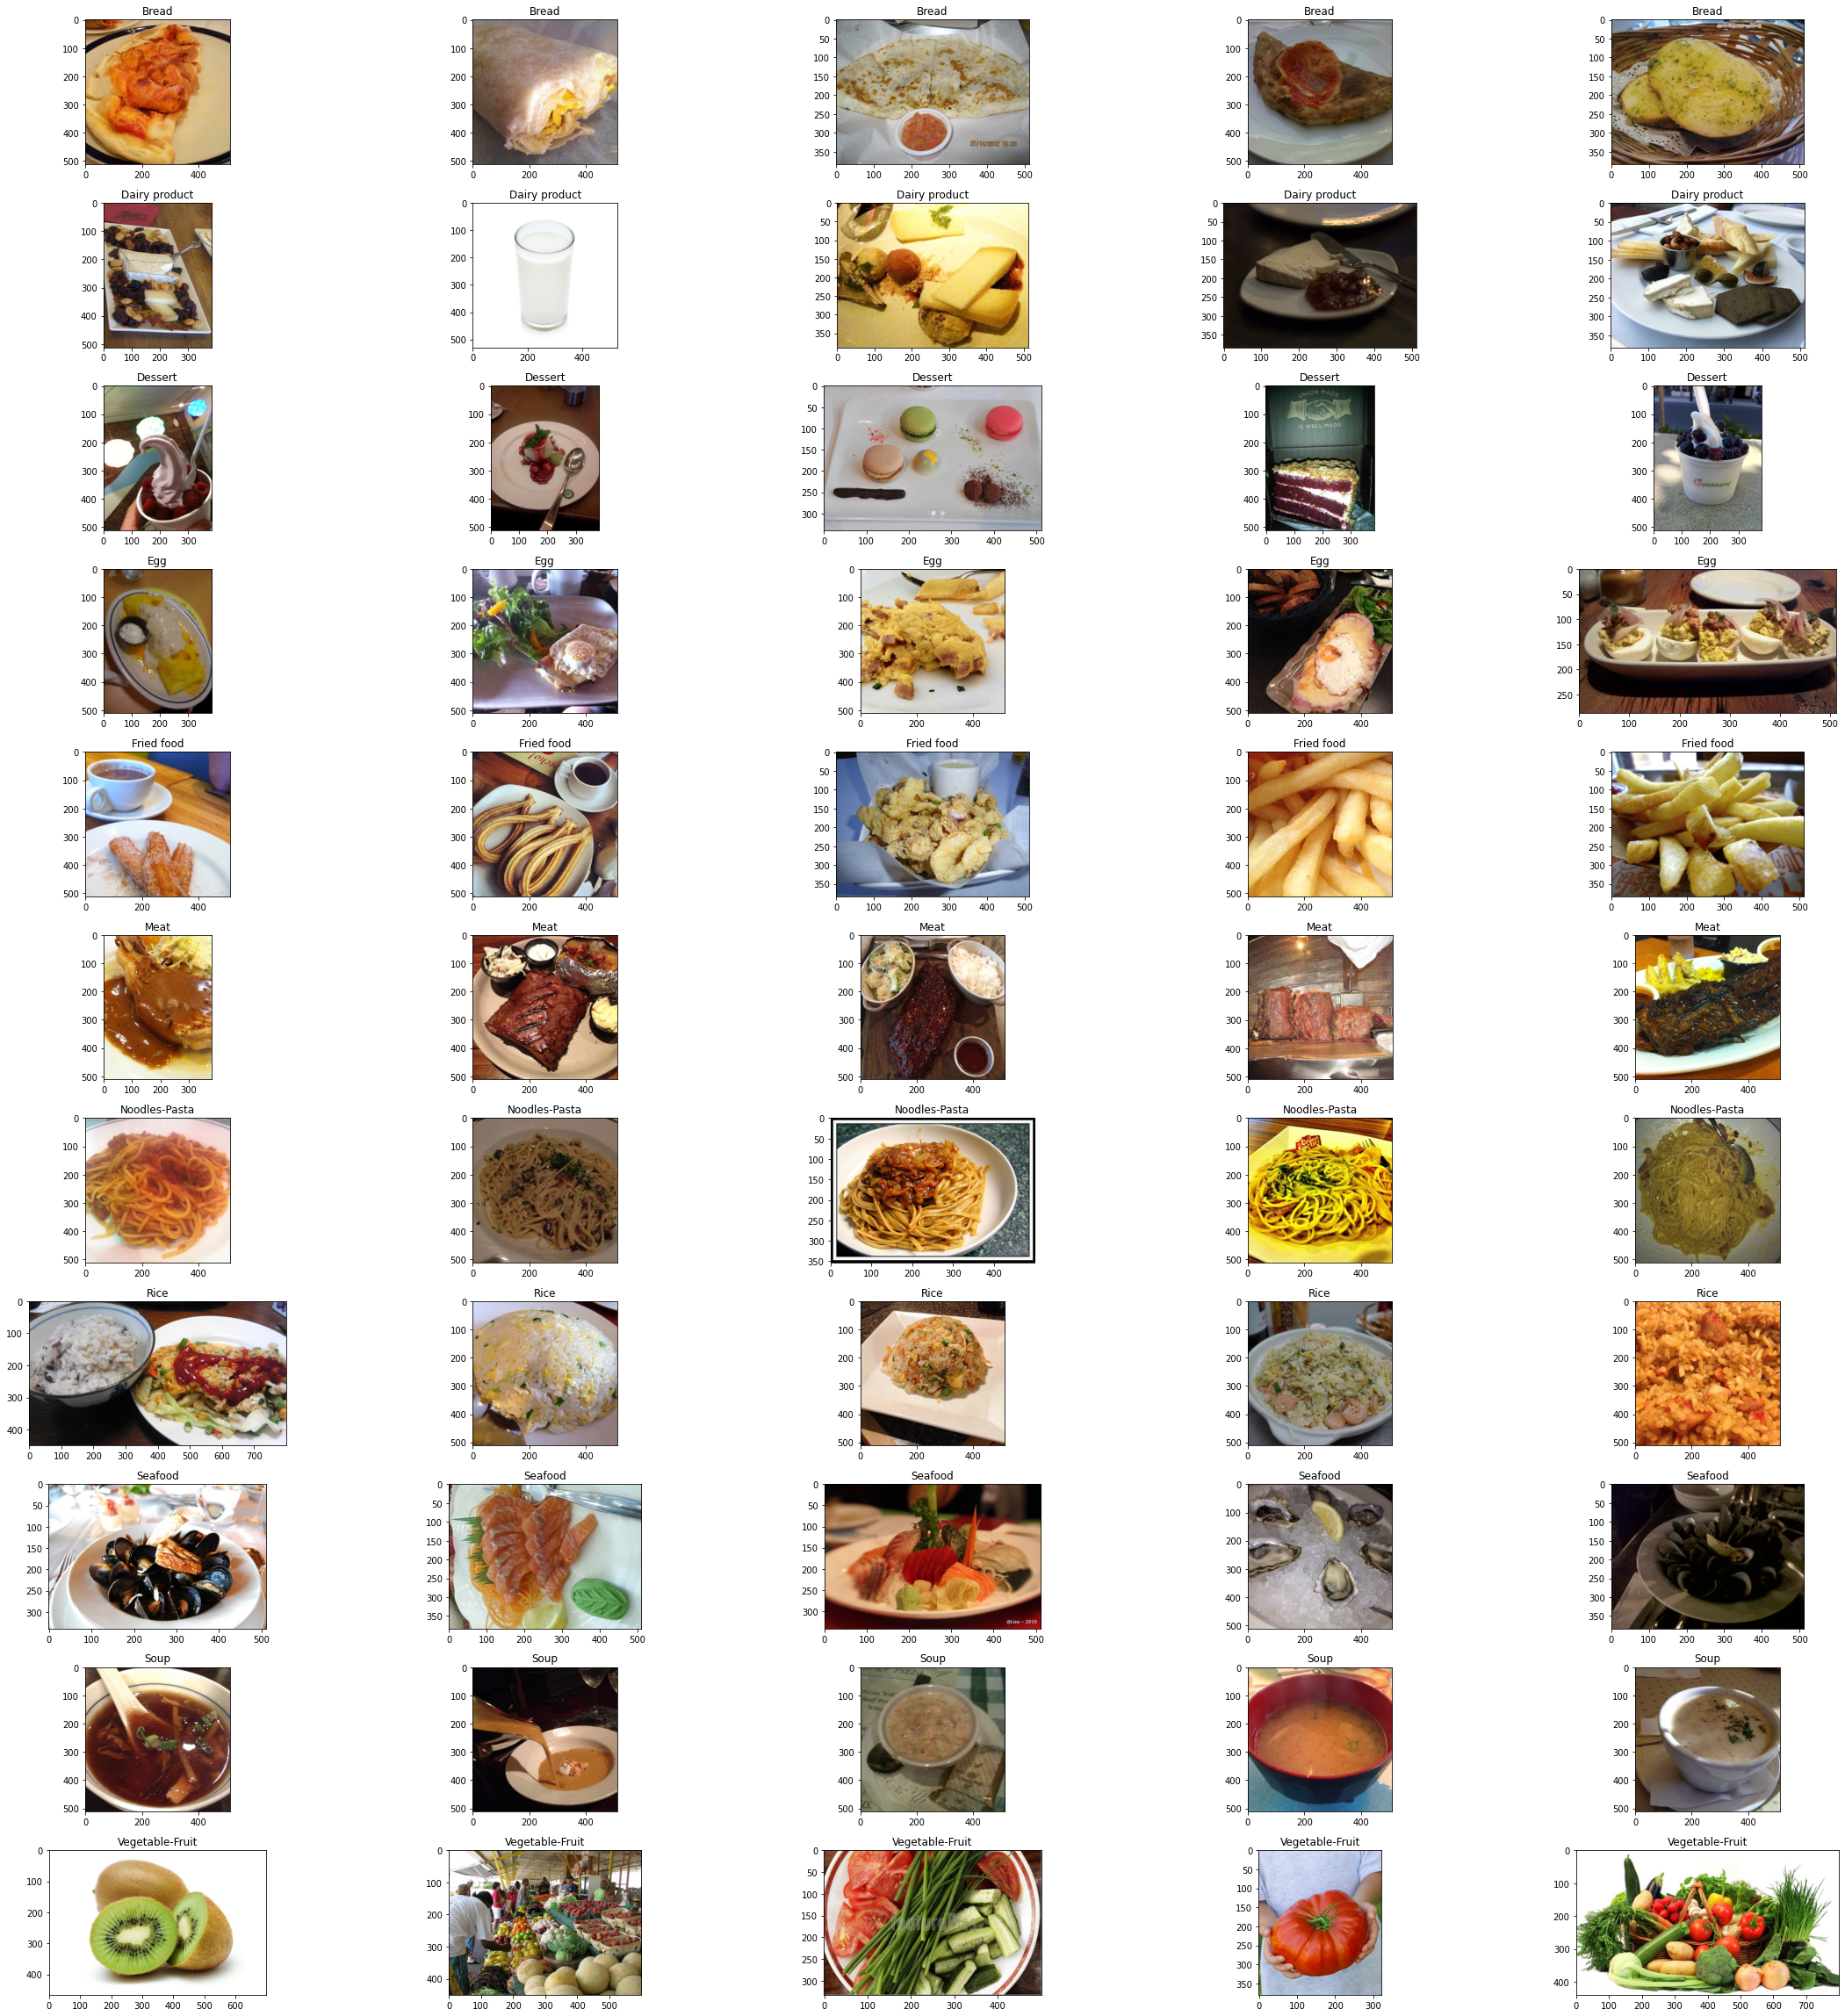

In [13]:
# Visualize the images in the validation data

fig, axes = plt.subplots(11,5, figsize=(32,32))
count = 0
for i in os.listdir('./validation'):
  # get the list of images in the particualr class 
  validation_class = os.listdir(os.path.join('validation',i))
  # plot 3 images per class
  for j in range(5):
    img = os.path.join('validation', i, validation_class[j])
    img = PIL.Image.open(img)
    axes[count][j].title.set_text(i)
    axes[count][j].imshow(img)  
  count += 1

fig.tight_layout()

In [11]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('./training'):
  Class_name.append(i)
  train_class = os.listdir(os.path.join('training',i))
  print('Number of images in {}={}\n'.format(i,len(train_class)))
  No_images_per_class.append(len(train_class))

Number of images in Bread=994

Number of images in Dairy product=429

Number of images in Dessert=1500

Number of images in Egg=986

Number of images in Fried food=848

Number of images in Meat=1325

Number of images in Noodles-Pasta=440

Number of images in Rice=280

Number of images in Seafood=855

Number of images in Soup=1500

Number of images in Vegetable-Fruit=709



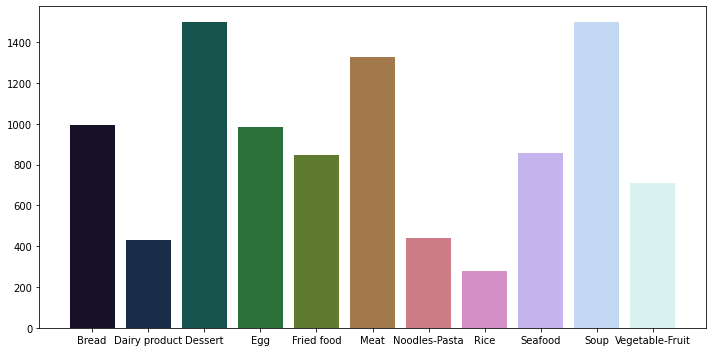

In [12]:
# Visualize the number of images in each class in the training dataset

fig = plt.figure(figsize=(10,5))
plt.bar(Class_name, No_images_per_class, color = sns.color_palette("cubehelix",len(Class_name)))
fig.tight_layout()

### Feature Engineering with Data Augmentation

In [15]:
# Create run-time augmentation on training and test dataset

train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                )

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
# Create data generator for training, validation and test dataset.

train_generator = train_datagen.flow_from_directory(
        'training',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 9866 images belonging to 11 classes.


In [17]:
validation_generator = test_datagen.flow_from_directory(
        'validation',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 3430 images belonging to 11 classes.


In [18]:
test_generator = test_datagen.flow_from_directory(
        'evaluation',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 3347 images belonging to 11 classes.


### Building the model with help of INCEPTIONRESNETV2 weights

In [19]:
# load the inception resnetv2 model
basemodel = InceptionResNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)) )

219062272/219055592 [==============================] - 142s 1us/step


In [20]:
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

conv2d_137 (Conv2D)             (None, 14, 14, 128)  139264      block17_15_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_137 (BatchN (None, 14, 14, 128)  384         conv2d_137[0][0]                 
__________________________________________________________________________________________________
activation_137 (Activation)     (None, 14, 14, 128)  0           batch_normalization_137[0][0]    
__________________________________________________________________________________________________
conv2d_138 (Conv2D)             (None, 14, 14, 160)  143360      activation_137[0][0]             
__________________________________________________________________________________________________
batch_normalization_138 (BatchN (None, 14, 14, 160)  480         conv2d_138[0][0]                 
__________________________________________________________________________________________________
activation

In [21]:
# Freeze the basemodel weights , so these weights won't change during training

basemodel.trainable = False

In [23]:
# Add classification head to the model

headmodel = basemodel.output

headmodel= GlobalAveragePooling2D(name = 'global_average_pool')(headmodel)

headmodel = Flatten(name = 'flatten')(headmodel)

headmodel = Dense(256, activation = 'relu', name='dense_1')(headmodel)

headmodel = Dropout(0.3)(headmodel)

headmodel = Dense(128, activation = 'relu', name='dense_2')(headmodel)

headmodel = Dropout(0.3)(headmodel)

headmodel = Dense(11, activation = 'softmax', name='dense_3')(headmodel)


model = Model(inputs = basemodel.input, outputs = headmodel)

### Training the model

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer= SGD(lr = 0.01, momentum = 0.9), metrics = ['accuracy'])

In [28]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [30]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 1, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer, earlystopping])

### Fine-tuning the model

In [31]:
# unfreeze the weights in the base model
basemodel.trainable = True

In [35]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights_fine.hdf5", verbose=1, save_best_only=True)

In [38]:
# fine tune the model with very low learning rate

model.compile(loss = 'categorical_crossentropy', optimizer= SGD(lr = 0.0001, momentum = 0.9), metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 10, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer, earlystopping])

### Assess  Model Performance

In [39]:
# Load the best model which I trained
model.load_weights("weights_fine.hdf5")

In [40]:
# Evaluate the performance of the model
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


104/104 [==============================] - 508s 5s/step - loss: 0.3399 - accuracy: 0.9042
Accuracy Test : 0.9011418223381042


In [41]:
# assigning label names to the corresponding indexes
labels = {0: 'Bread', 1: 'Dairy product', 2: 'Dessert', 3:'Egg', 4: 'Fried food', 5:'Meat',6:'Noodles-Pasta',7:'Rice', 8:'Seafood',9:'Soup',10: 'Vegetable-Fruit'}

In [43]:
# loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir('./evaluation'):
  for item in os.listdir(os.path.join('./evaluation',i)):

    img= PIL.Image.open(os.path.join('./evaluation',i,item))
    #resizing the image to (256,256)
    img = img.resize((256,256))
    #appending image to the image list
    image.append(img)
    #converting image to array
    img = np.asarray(img, dtype= np.float32)
    #normalizing the image
    img = img / 255
    #reshaping the image in to a 4D array
    img = img.reshape(-1,256,256,3)
    #making prediction of the model
    predict = model.predict(img)
    #getting the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #appending the predicted class to the list
    prediction.append(labels[predict])
    #appending original class to the list
    original.append(i)


In [ ]:
# visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
# classification report
print(classification_report(np.asarray(original),np.asarray(prediction)))

In [ ]:
# plot confusion matrix

plt.figure(figsize=(20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')
